In [61]:
import os
os.chdir('/home/dgotzens/scripts/')

from torch.fft import fft,ifft,fftshift,ifftshift
import matplotlib.pyplot as plt
import tools, torch
import numpy as np

# Backprojection

In [62]:
import timedataparser
header,_,realdata,_,params = timedataparser.load_all('/home/dgotzens/recording/23-11-20/', loadfeparams=True)

M,K,L = (1024,192,1)
X,Y,Z = (256,3,128)
I = X*Y*Z
c0 = 299_792_458
β = params['RampSlope']
fs = 22e6

rmax = 5
rx = torch.linspace(-rmax, rmax, X)[:,None,None].expand((X,Y,Z))
ry = torch.linspace(-0.1*rmax, 0.1*rmax, Y)[None,:,None].expand((X,Y,Z))
rz = torch.linspace(0,rmax,Z)[None,None,:].expand((X,Y,Z))

data = torch.zeros((M,K,L),dtype=torch.cfloat)

# data[:,:,0] = torch.exp(-0.44j*torch.arange(M)).unsqueeze(-1)

loaded data with shape torch.Size([1022, 192, 9])


Target at $r_0=3.5m$
 
Ramp slope $\beta = 66GHz/s$
 
Sample rate $f_s = 22MHz$
 
$x_0 (t) \sim e^{-j2\pi \beta \frac{2r_0}{c_0} t} =: e^{-j\Omega m}$
 
$\Rightarrow \Omega = 0.440 $



$2\pi \beta \frac{2r_0}{c_0f_s} \approx 0.471$
$\Rightarrow r_0 = 0.471 \frac{c_0f_s}{4 \pi \beta} = 3.748m$

In [63]:
# assume constant antenna gain
g = torch.ones((K,X,Y,Z))

# calculate runtimes
dist = torch.empty((K,X,Y,Z))
for k in range(K):
    dist[k,...] =  ((params['txPosX'][k] - rx)**2 + abs(params['txPosY'][k] - ry)**2 + rz**2).sqrt()\
                 + ((params['rxPosX'][k] - rx)**2 + abs(params['rxPosY'][k] - ry)**2 + rz**2).sqrt()
    
tau = lambda x,y,z : dist[:,(rx[:,0,0]-x).abs().argmin(), \
                            (ry[0,:,0]-y).abs().argmin(), \
                            (rz[0,0,:]-z).abs().argmin()]/c0/fs
point = lambda x,y,z : torch.exp(-2j*torch.pi*β * tau(x,y,z) * torch.arange(M).unsqueeze(-1))
data[:,:,0] = point(0,0,rmax/2) + point(-rmax/2,0,rmax/2)

100%


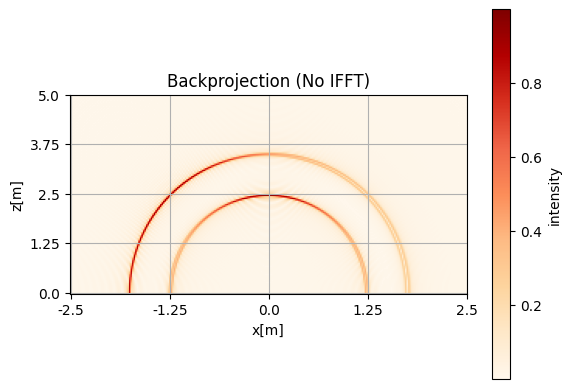

In [64]:
img = torch.empty((X,Z),dtype=torch.cfloat)
exp = torch.empty((M,K),dtype=torch.cfloat)
# window = torch.hann_window(M).unsqueeze(-1).unsqueeze(-1)
for x in range(X):
    if x%10:
        print(f'{round(100*x/X)}%', end='\r'if x < X-1 else '\n')
    for z in range(Z):
        exp = torch.exp(\
            2j*torch.pi*β*dist[:,x,Y//2,z]/(c0*fs)*torch.arange(M).unsqueeze(-1))\
                .unsqueeze(-1)
        img[x,z] = (exp * data).mean()
plt.imshow(img.abs().T,cmap='OrRd', origin='lower')
plt.xticks(range(0,X+1,X//4), [rmax/4*i for i in range(-2,2+1)])
plt.yticks(range(0,Z+1,Z//4), [rmax/4*i for i in range(4+1)])
plt.xlabel('x[m]')
plt.ylabel('z[m]')
plt.colorbar(label='intensity')
plt.grid()
plt.title('Backprojection (No IFFT)')
plt.show()

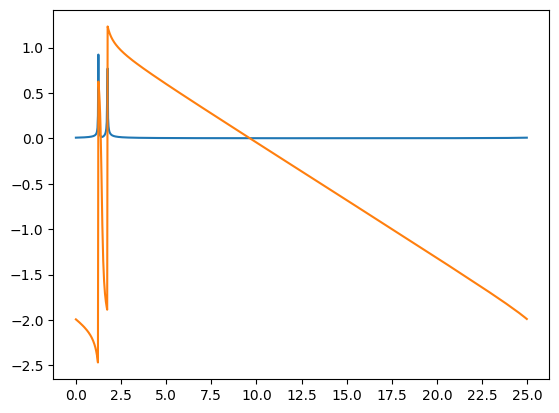

/tmp/ipykernel_3249736/1268701379.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


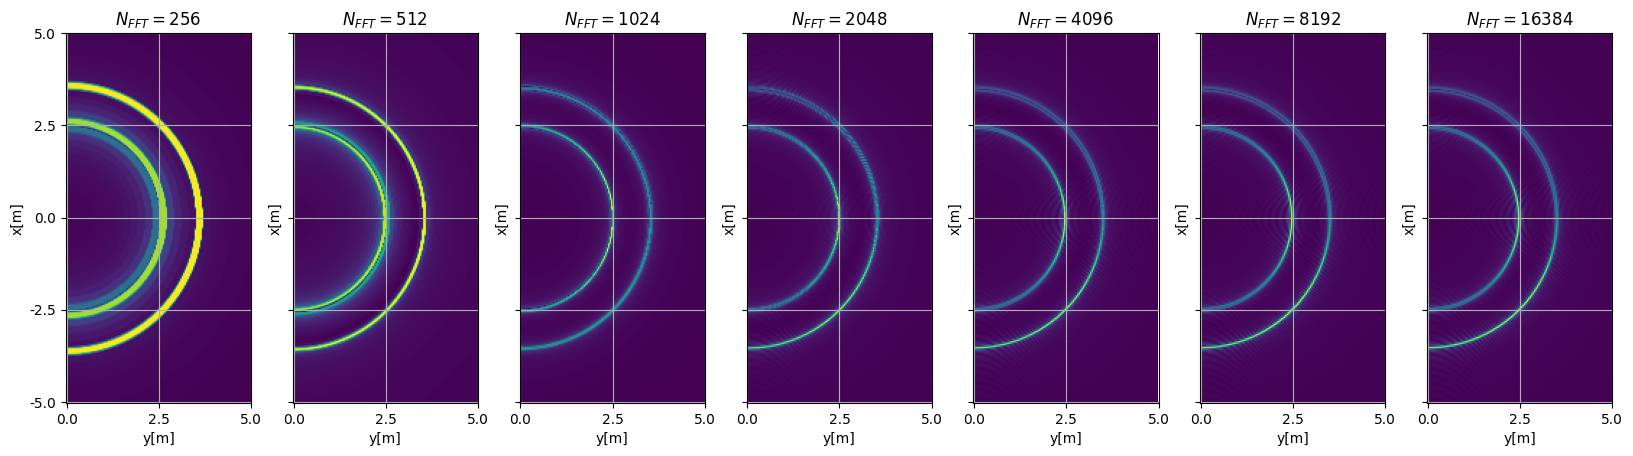

In [139]:
nfft = data.shape[0]
plt.plot(ifft(data[:,0,0]).abs())
plt.plot(ifft(data[:,0,0]).angle())
plt.xticks([nfft/10*i for i in range(11)], [25/10*i for i in range(11)])
plt.show()
f,ax = plt.subplots(1,7,sharey=True)
f.set_figwidth(20)
for n in range(7):
    nfft = 256*2**n
    img_fft = torch.zeros((X,Z),dtype=torch.cfloat)
    # window = torch.hann_window(M)
    # window = torch.hamming_window(M)
    window = torch.ones(M)
    for k in range(K):
        index = (β*dist[k,:,Y//2,:]/(c0*fs)*nfft).flatten(0)
        img_fft += ifft(window*data[:,k,0], n=nfft)[index.long()].unflatten(0,(X,Z))

    ax[n].imshow(img_fft.abs()/K, origin='lower')
    ax[n].set_yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
    ax[n].set_xticks(range(0,Z+1,Z//2), [rmax/2*i for i in range(2+1)])
    ax[n].set_ylabel('x[m]')
    ax[n].set_xlabel('y[m]')
    ax[n].grid()
    ax[n].set_title(r'$N_{FFT}=$' + f'{nfft}')
f.show()

torch.Size([192])


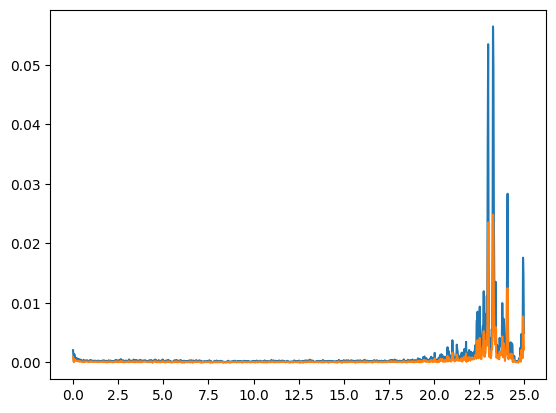

/tmp/ipykernel_3249736/1150425863.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


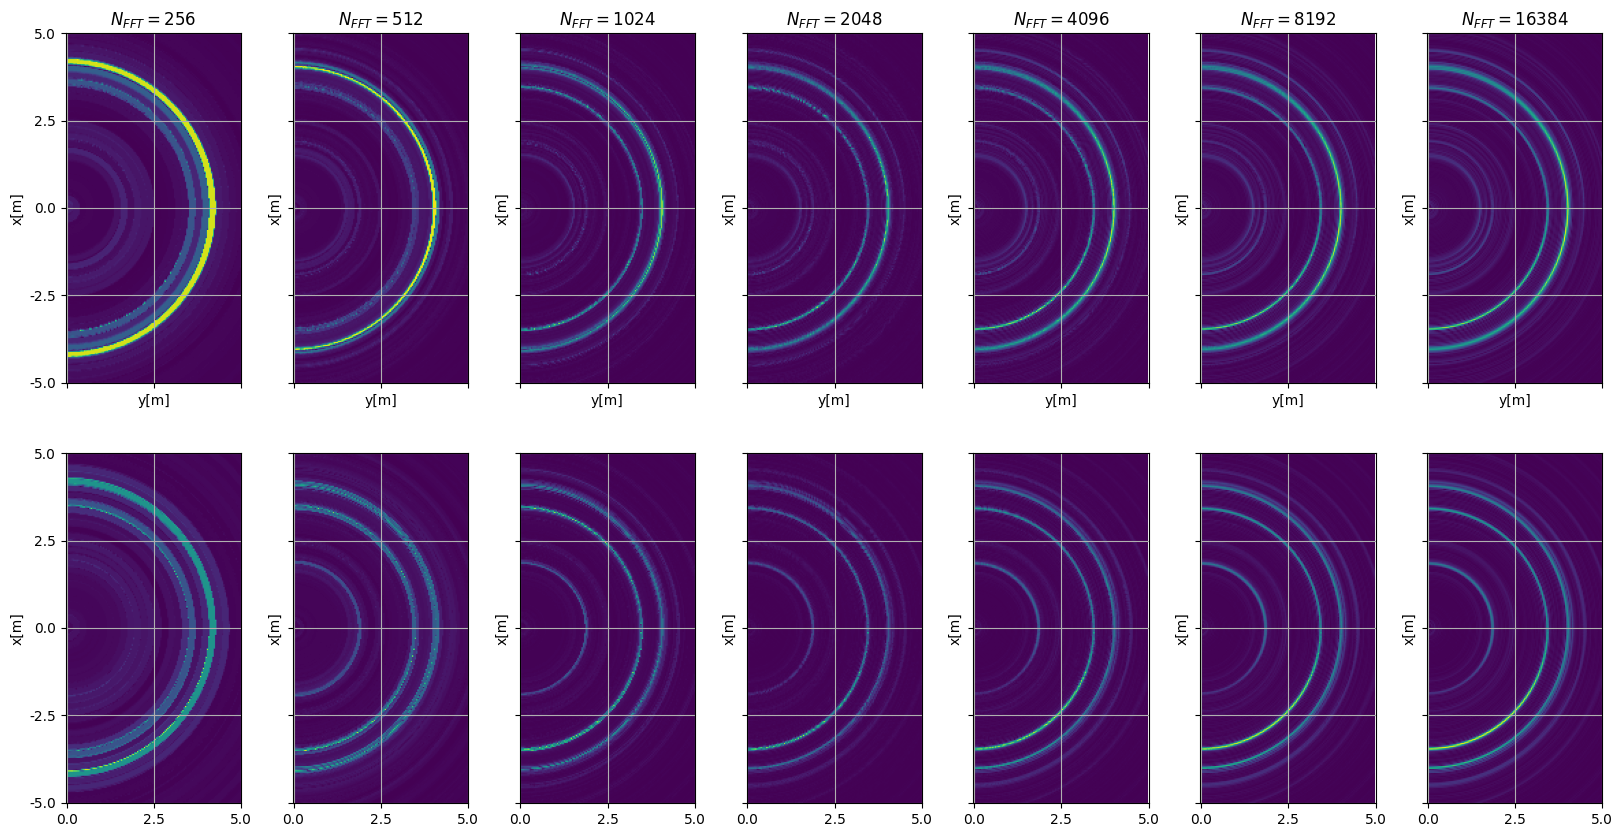

In [140]:
nfft = 1022

rangedata = fft(realdata[:,:,0], n=nfft, dim=0)
search_idx = torch.tensor([m for m,r in enumerate(tools.ranges(header, nfft)) if 3<r<3.8])
m_refl = tools.reflidx(rangedata.mean(1), search_idx)
weight = rangedata[m_refl,:]
print(weight.shape)
calibrated = ifft(rangedata/weight.conj(), n=nfft, dim=0)

plt.plot(ifft(realdata[:,0,0]).abs())
plt.plot(ifft(-calibrated[:,0]).abs())
plt.xticks([nfft/10*i for i in range(11)], [25/10*i for i in range(11)])
plt.show()

f,ax = plt.subplots(2,7,sharex=True,sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
for n in range(7):
    nfft = 256*2**n
    img_fft = torch.zeros((X,Z),dtype=torch.cfloat)
    img_fft_calib = torch.zeros((X,Z),dtype=torch.cfloat)
    # window = torch.hann_window(M)
    # window = torch.hamming_window(M)
    # window = torch.ones(calibrated.shape[0])
    for k in range(K):
        index = (β*dist[k,:,Y//2,:]/(c0*fs)*nfft).flatten(0)
        img_fft += ifft(realdata.conj()[:,k,0], n=nfft)[index.long()].unflatten(0,(X,Z))
        img_fft_calib += ifft(calibrated.conj()[:,k], n=nfft)[index.long()].unflatten(0,(X,Z))

    ax[0,n].imshow(img_fft.abs().exp()/K, origin='lower')
    ax[1,n].imshow(img_fft_calib.abs().exp()/K, origin='lower')
    ax[0,n].set_yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
    ax[1,n].set_yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
    ax[1,n].set_xticks(range(0,Z+1,Z//2), [rmax/2*i for i in range(2+1)])
    ax[0,n].set_ylabel('x[m]')
    ax[1,n].set_ylabel('x[m]')
    ax[0,n].set_xlabel('y[m]')
    ax[0,n].grid()
    ax[1,n].grid()
    ax[0,n].set_title(r'$N_{FFT}=$' + f'{nfft}')
f.show()

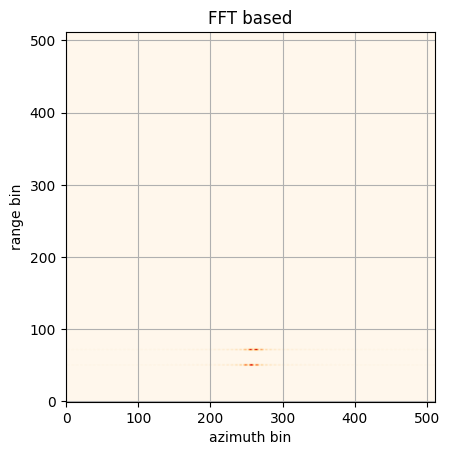

In [67]:
ula_idx = tools.ula_idx(header)
window = torch.hann_window(len(ula_idx))
nfft = 1024
rangedata = tools.rangedata(data.conj(), nfft)/nfft
azimuth = ifftshift(fft(fftshift(window*rangedata[:,ula_idx,0]), dim=1, n=512))/len(ula_idx)
plt.imshow(azimuth[:nfft//2,:].abs(), origin='lower',cmap='OrRd')
plt.grid()
plt.title('FFT based')
plt.xlabel('azimuth bin')
plt.ylabel('range bin')
plt.show()